In [17]:
import sys
sys.path.extend(['/home/Documents/tdbempp-master/tdbempp'])
# sys.path.extend(['/home/yiannis/bempp/build3/python_package'])
# sys.path.extend(['/home/yiannis/bempp/python'])
import numpy as _np
import bempp.api
import structures
import numpy.fft as fft
from convolution_quadrature import backward_euler,bdf2
import waves
import solver1 # this has been changed in the solver file to remove *confusion* with the solver from the EquispacedTimeStepsToFrequency class. Will be changed in a later version for greater transparency 

The above commands are necessary to import various modules

In [6]:
from ipyparallel import Client
import ipyparallel

rc = Client()

print (rc.ids) #checks all engines have been started correctly.

dview = rc[:] #gives us direct view/control over the engines

ImportError: No module named 'ipyparallel'

In [7]:
grid = bempp.api.shapes.sphere(h=0.1)
space = bempp.api.function_space(grid, "DP", 0)
interpolation_points = space.global_dof_interpolation_points

The above three commands define the grid and space on which the solver works on, aswell as the interpolation points used further on for the computation of the wave value across certain points.

In [8]:
solver = structures.EquispacedTimeStepsToFrequencyFactory(343, backward_euler, 0.95, 20E-3, 5, 5) #changed the final_time value
time_steps = solver.time_steps
freq_steps = solver.frequency_steps
wavenumbers = solver.wavenumbers
radius = solver.radius
number_of_time_steps = solver.number_of_time_steps
number_of_frequencies = solver._number_of_frequencies
frequencies = solver.frequency_steps

The above command calls the EquispacedTimeStepsToFrequencyFactory Class. This class takes inputs of speed,convolution quadrature method, radius of the contour on which the z-transform acts,the final time, and number of time steps/frequencies (Currently the code is only stable for same number of timesteps/frequencies.
Wavenumbers are calculated via the class to be used later on.

In [9]:
direction = _np.array([1,0,0])
wave = waves.GaussianIncidentWave(400, direction, 343, 10E-3, 6/(2000*_np.pi))
boundary_data = structures.AnalyticTimeDomainBoundaryData(interpolation_points,1,wave)
boundary_data_values = boundary_data.evaluate(time_steps)

Direction is the direction of the incoming (acoustic) wave.
Wave here is from the GaussianIncidentWave class, which takes parameters frequency, direction, speed, tp, sigma
The AnalyticTimeDomainBoundaryData class takes parameters interpolation_points,dimension(1) (which is no longer needed), and the type of wave, in this case acoustic. The evaluate property of this class, allows us to evaluate the boundary data at specific times, given in this case by the time_steps.

In [10]:
n_grid_points = 300
plot_grid = _np.mgrid[-3:3:n_grid_points*1j,-3:3:n_grid_points*1j]
points = _np.vstack((plot_grid[0].ravel(),plot_grid[1].ravel(),_np.zeros(plot_grid[0].size)))

Here we define the number of points our grid has in each coordinate. In this case , we have 300x points and 300y coordinates to create our grid, from -3 to 3 in both instances.

In [11]:
solution = _np.zeros((number_of_frequencies, n_grid_points, n_grid_points),dtype="complex128") 

boundary_data_values_transform = solver.forward_transform(boundary_data_values)

The solution creates an array of zeros, so the solution can be stored.
The boundary_data_values_transform stores the forward-transformed boundary values

In [18]:
#with dview.sync_imports():
    #import sys
    #sys.path.extend(['/home/yiannis/PycharmProjects/Tdbempp'])
    #sys.path.extend(['/home/yiannis/bempp/build3/python_package'])
    #sys.path.extend(['/home/yiannis/bempp/python'])
    #import numpy as _np
    #import bempp.api
    #import Tdbempp.structures
    #import numpy.fft as fft
    #from Tdbempp.convolution_quadrature import backward_euler,bdf2
    #import Tdbempp.waves
    #import Tdbempp.solver

def solver_parallel_bem(index,wavenumber,boundary_data):
    acoustic = solver1.SolveAcousticHelmholtz(wavenumber, space, n_grid_points, points)
    solution[index,:,:] = acoustic.solve_single_layer(boundary_data)
    
for i,(j,k) in enumerate(zip(wavenumbers, boundary_data_values_transform[:,])):
    solver_parallel_bem(i,j,k)

The above for loop, goes through each boundary_value and wavenumber, passes them onto the BEM++ solver which is interfaced via the solver class, and uses a single layer solution to get the desired result, storing it into the solution array.

In [19]:
solution = solver.inverse_transform(solution)

new_solution = _np.zeros_like(solution)

Our solution has been calculated in the z-domain, and now we inversely transform it back into the time domain.

In [20]:
for index,t in enumerate(time_steps):
    vals = wave.value(t,points)
    new_solution[index,:,:]=vals.reshape(n_grid_points,n_grid_points)
solution = - new_solution +  solution

#TODO, Explain better

In [21]:
radius_grid = _np.sqrt(plot_grid[0] ** 2 + plot_grid[1] ** 2)
solution[:,radius_grid < 1] = _np.nan # Filter out solution values that are associated with points outside the unit circle."""

In this specific case, we care about the external solution. Therefore the interior is excluded from our graphs.

In [22]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5.0, 5.0) # Adjust the figure size in IPython
from matplotlib import pyplot as plt

The %matplotlib inline allows us to show graphs inside the Ipython Notebook.

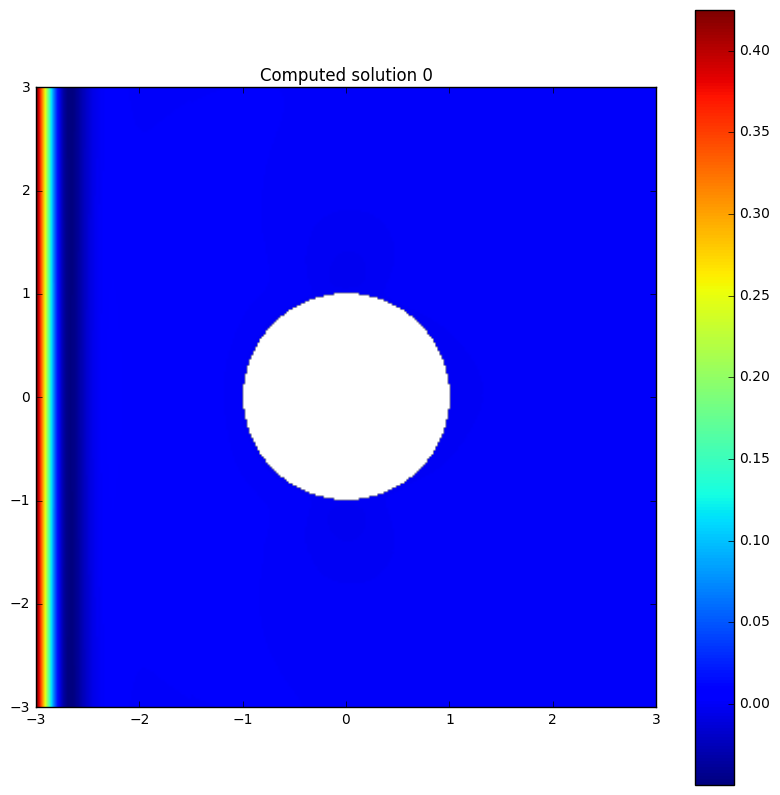

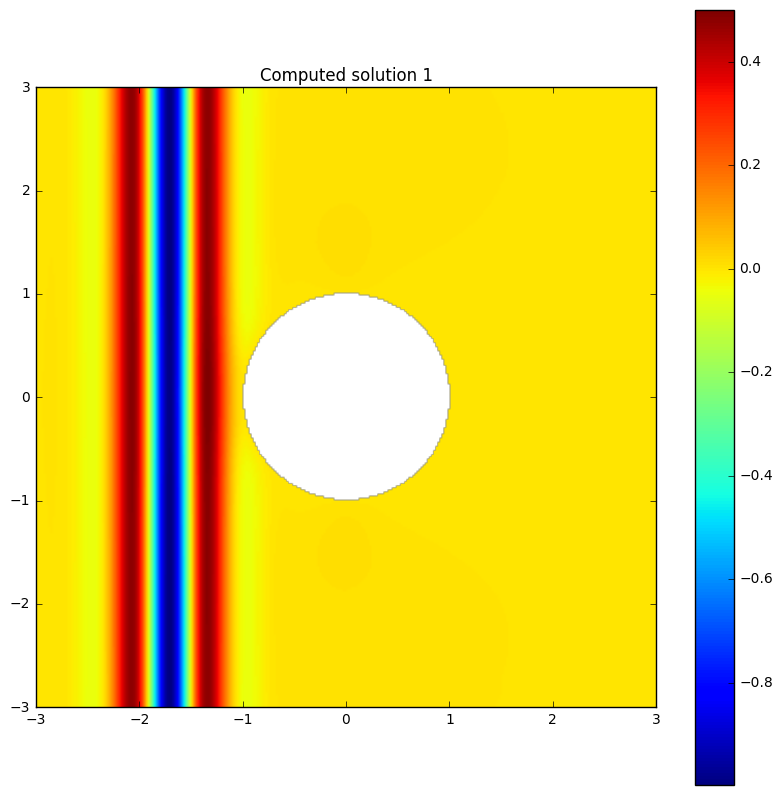

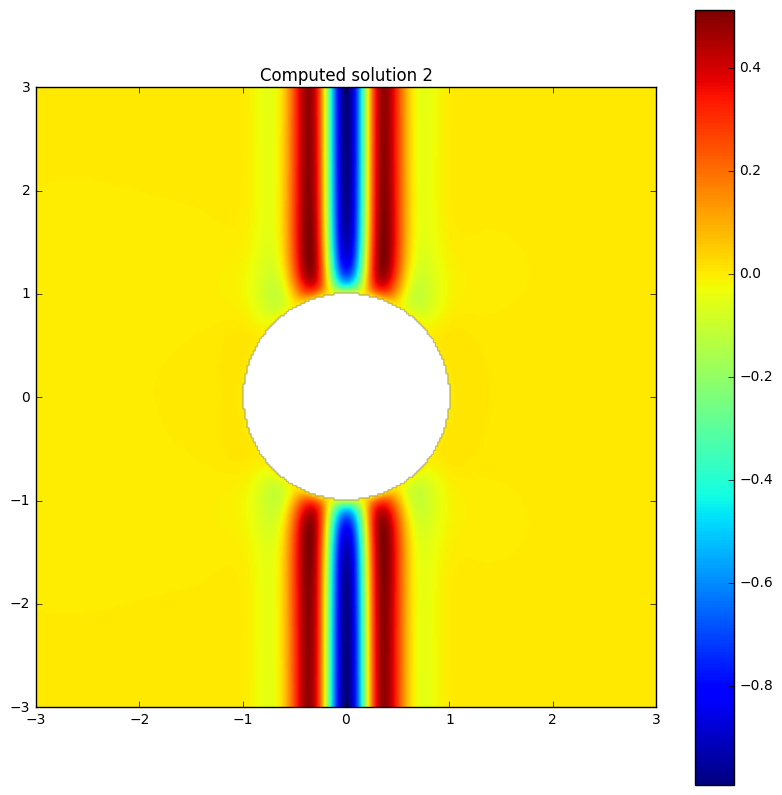

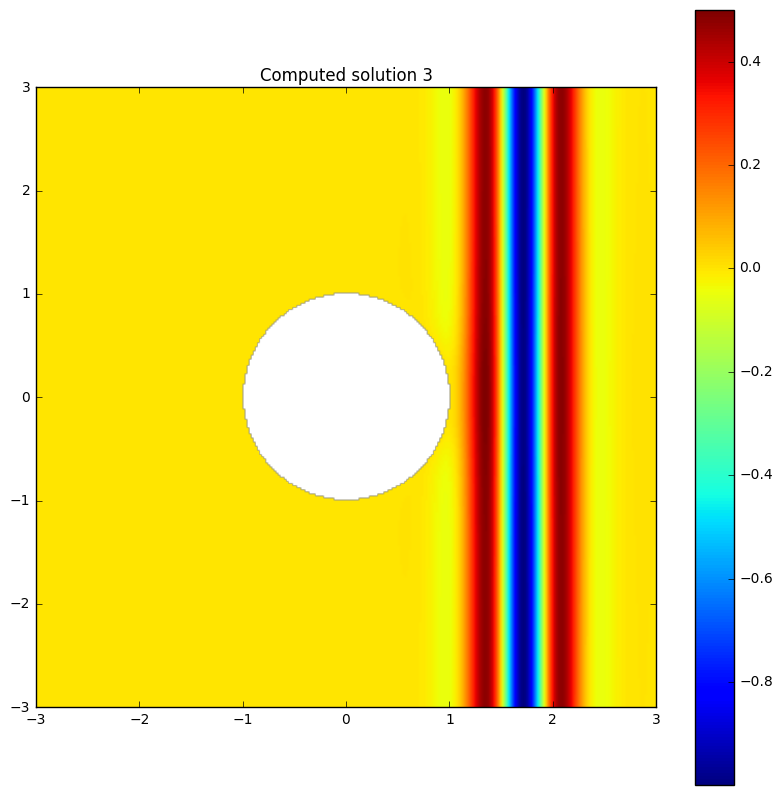

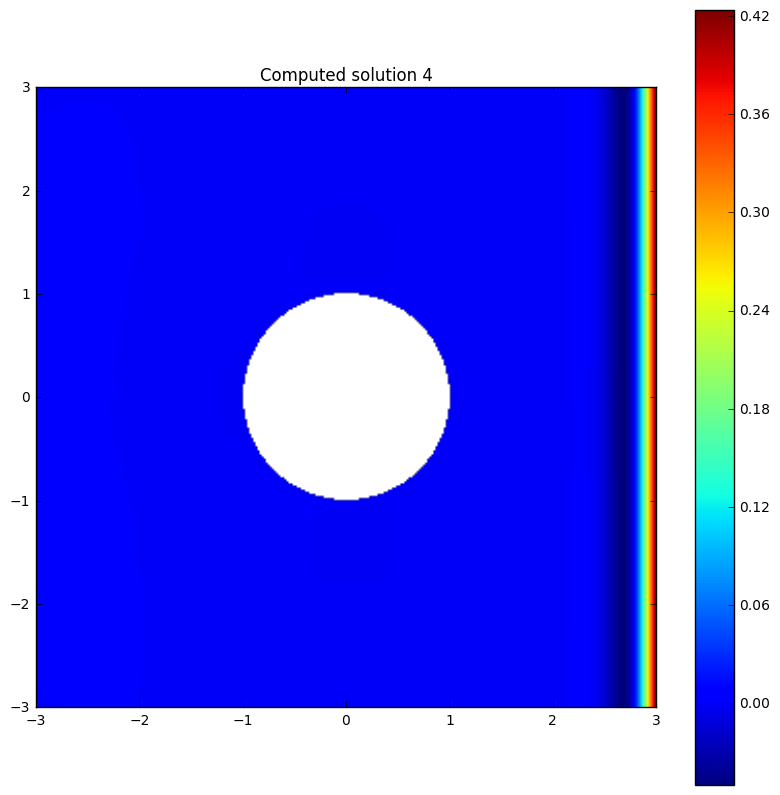

In [24]:
for i,j in enumerate(time_steps):
    plt.figure(num=i,figsize=(10,10),dpi=1200)
    plt.imshow(_np.real(solution[i,:,:].T), extent=(-3,3,-3,3),origin='lower') #changing the transpose.T at end
    plt.title('Computed solution %i' %i)
    plt.colorbar()
    plt.show()
    plt.close()

The above command loops through the time_steps and saves each figure in the desired location for access at a later stage.